In [1]:
# Imports
import pathlib
from transformations import ComposeDouble, normalize_01, AlbuSeg2d, FunctionWrapperDouble, create_dense_target
from sklearn.model_selection import train_test_split
from customdatasets import SegmentationDataSet3
import torch
import numpy as np
from unet import UNet
from trainer import Trainer
from torch.utils.data import DataLoader
from skimage.transform import resize
import albumentations


In [2]:
def get_filenames_of_path(path: pathlib.Path, ext: str = '*'):
    """Returns a list of files in a directory/path. Uses pathlib."""
    filenames = [file for file in path.glob(ext) if file.is_file()]
    return filenames

In [3]:
# root directory
root = pathlib.Path.cwd() / 'Data' / '2018'

# input and target files
inputs = get_filenames_of_path(root / 'ISIC2018_Task1-2_Training_Input', ext='*.jpg')
targets = get_filenames_of_path(root / 'ISIC2018_Task1_Training_GroundTruth', ext='*.png')

# use small set of data for demo
# inputs = inputs[:200]
# targets = targets[:200]

In [4]:
# pre-transformations
pre_transforms = ComposeDouble([
    FunctionWrapperDouble(resize,
                          input=True,
                          target=False,
                          output_shape=(128, 128, 3)),
    FunctionWrapperDouble(resize,
                          input=False,
                          target=True,
                          output_shape=(128, 128),
                          order=0,
                          anti_aliasing=False,
                          preserve_range=True),
])

# training transformations and augmentations
transforms_training = ComposeDouble([
    AlbuSeg2d(albumentations.HorizontalFlip(p=0.5)),
    FunctionWrapperDouble(create_dense_target, input=False, target=True),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
    FunctionWrapperDouble(normalize_01)
])

# validation transformations
transforms_validation = ComposeDouble([
    FunctionWrapperDouble(resize,
                          input=True,
                          target=False,
                          output_shape=(128, 128, 3)),
    FunctionWrapperDouble(resize,
                          input=False,
                          target=True,
                          output_shape=(128, 128),
                          order=0,
                          anti_aliasing=False,
                          preserve_range=True),
    FunctionWrapperDouble(create_dense_target, input=False, target=True),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
    FunctionWrapperDouble(normalize_01)
])


In [5]:
# random seed
random_seed = 42

# split dataset into training set and validation set
train_size = 0.8  # 80:20 split

inputs_train, inputs_valid, targets_train, targets_valid = train_test_split(
    inputs,
    targets,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

In [6]:
# dataset training
dataset_train = SegmentationDataSet3(inputs=inputs_train,
                                    targets=targets_train,
                                    transform=transforms_training,
                                    use_cache=True,
                                    pre_transform=pre_transforms)

# dataset validation
dataset_valid = SegmentationDataSet3(inputs=inputs_valid,
                                    targets=targets_valid,
                                    transform=transforms_validation,
                                    use_cache=True,
                                    pre_transform=pre_transforms)

# dataloader training
dataloader_training = DataLoader(dataset=dataset_train,
                                 batch_size=2,
                                 shuffle=True)

# dataloader validation
dataloader_validation = DataLoader(dataset=dataset_valid,
                                   batch_size=2,
                                   shuffle=True)

In [7]:
# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# model
model = UNet(in_channels=3,
             out_channels=2,
             n_blocks=4,
             start_filters=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2).to(device)

# criterion
criterion = torch.nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=dataloader_training,
                  validation_DataLoader=dataloader_validation,
                  lr_scheduler=None,
                  epochs=10,
                  epoch=0,
                  notebook=True)

# start training
training_losses, validation_losses, lr_rates = trainer.run_trainer()

Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1038 [00:00<?, ?it/s]

c:\users\xyz\dropbox\selfprojects\py38_pytorch_gpu\venv\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Training:   0%|          | 0/1038 [00:00<?, ?it/s]

Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Training:   0%|          | 0/1038 [00:00<?, ?it/s]

Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Training:   0%|          | 0/1038 [00:00<?, ?it/s]

Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Training:   0%|          | 0/1038 [00:00<?, ?it/s]

Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Training:   0%|          | 0/1038 [00:00<?, ?it/s]

Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Training:   0%|          | 0/1038 [00:00<?, ?it/s]

Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Training:   0%|          | 0/1038 [00:00<?, ?it/s]

Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Training:   0%|          | 0/1038 [00:00<?, ?it/s]

Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Training:   0%|          | 0/1038 [00:00<?, ?it/s]

Validation:   0%|          | 0/260 [00:00<?, ?it/s]

In [8]:
training_losses, validation_losses, lr_rates

([0.339841158224381,
  0.24331208481408498,
  0.2151908856746606,
  0.20152427081327332,
  0.18639869591031,
  0.18912449246182722,
  0.1769296547078558,
  0.17249510221556547,
  0.16748490089080467,
  0.16770219177309142],
 [0.3121738564223051,
  0.3773736634506629,
  0.39370856104561913,
  0.3299634858679313,
  0.2300106449267612,
  0.3112547279550479,
  0.23149387476106104,
  0.2060712093917223,
  0.27205348301392335,
  0.2275289839420181],
 [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])

In [9]:
# save the model
model_name =  'model_epochs-10_lr-002.pt'
torch.save(model.state_dict(), pathlib.Path.cwd() / model_name)

# Learning rate finder

In [10]:
# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    torch.device('cpu')

# model
model = UNet(in_channels=3,
             out_channels=2,
             n_blocks=4,
             start_filters=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2).to(device)

# criterion
criterion = torch.nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [11]:
from lr_rate_finder import LearningRateFinder
lrf = LearningRateFinder(model, criterion, optimizer, device)
lrf.fit(dataloader_training, steps=1000)

Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/1038 [00:00<?, ?it/s]

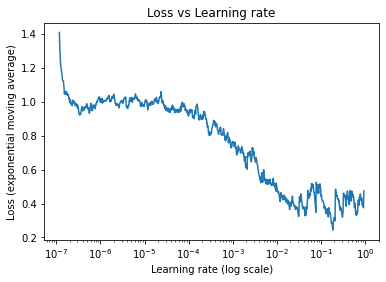

In [12]:
lrf.plot()

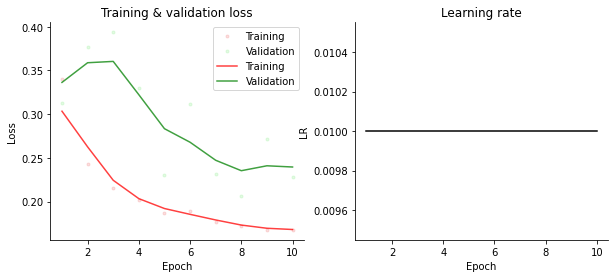

In [13]:
from visual import plot_training
fig = plot_training(training_losses, validation_losses, lr_rates, gaussian=True, sigma=1, figsize=(10, 4))

In [14]:
fig.savefig("fig_epochs-10_lr-002.jpg")